In [1]:
# ----------------------------------------------------------------------------
# Author        :    Vasileios Perifanis
# Affiliation   :    Euclid team, Democritus University of Thrace, Dept. of Electrical & Computer Engineering
# Created Date  :    03/2022
# version       :    1.0
# ---------------------------------------------------------------------------

In [2]:
import numpy as np # linear algebra
import pandas as pd # data analysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing


from sklearn.utils import resample

from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
data = pd.read_csv("datasets/titanic_train.csv", header=0) # read csv

data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #extract the Salutations

# Assigning the NaN Values the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

data['Embarked'].fillna('S',inplace=True)

data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4

data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

data['Fare_Range']=pd.qcut(data['Fare'],5)
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

data.drop(['Name','Age','Ticket','Fare','Cabin','Initial','Fare_Range','PassengerId'],axis=1,inplace=True)

data.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_band,Family_Size,Alone,Fare_cat
0,0,3,0,1,0,0,1,1,0,0
1,1,1,1,1,0,1,2,1,0,3
2,1,3,1,0,0,0,1,0,1,1
3,1,1,1,1,0,0,2,1,0,3
4,0,3,0,0,0,0,2,0,1,1


In [4]:
def train_sk(train_X, train_Y, test_X, test_Y):
    # initialize classifier
    classifier = MLPClassifier(hidden_layer_sizes=(32,16,8), random_state=0, max_iter=1000)

    # train the classifier
    classifier.fit(train_X,train_Y)

    # make predictions on train/test set
    y_pred_train = classifier.predict(train_X)
    y_pred = classifier.predict(test_X)

    # calculate scores
    accuracy_train = accuracy_score(y_pred_train, train_Y)
    precision_train = precision_score(y_pred_train, train_Y)
    recall_train = recall_score(y_pred_train, train_Y)
    f1_train = f1_score(y_pred_train, train_Y)

    accuracy = accuracy_score(y_pred, test_Y)
    precision = precision_score(y_pred, test_Y)
    recall = recall_score(y_pred, test_Y)
    f1 = f1_score(y_pred, test_Y)

    print(f"[Training set] Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}\n",
          f"[Testing set] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    return accuracy, precision, recall, f1

In [5]:
def split(data):
    train,test=train_test_split(data,test_size=0.2,random_state=0,stratify=data['Survived'])
    return train, test
def to_numpy(train, test):
    train_X=train[train.columns[1:]].to_numpy()
    train_Y=train[train.columns[:1]].to_numpy().ravel()
    test_X=test[test.columns[1:]].to_numpy()
    test_Y=test[test.columns[:1]].to_numpy().ravel()
    return train_X, train_Y, test_X, test_Y

In [6]:
data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
train, test = split(data)

In [8]:
train.Survived.value_counts()

0    439
1    273
Name: Survived, dtype: int64

In [9]:
test.Survived.value_counts()

0    110
1     69
Name: Survived, dtype: int64

In [10]:
dict(test.Survived.value_counts())

{0: 110, 1: 69}

In [11]:
accuracy, precision, recall, f1 = dict(), dict(), dict(), dict()

In [12]:
train_X, train_Y, test_X, test_Y = to_numpy(train, test)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)

In [13]:
acc, prec, rec, f = train_sk(train_X, train_Y, test_X, test_Y)
accuracy['baseline'] = acc
precision['baseline'] = prec
recall['baseline'] = rec
f1['baseline'] = f

[Training set] Accuracy: 0.8596, Precision: 0.7326, Recall: 0.8811, F1: 0.8000
 [Testing set] Accuracy: 0.7765, Precision: 0.5942, Recall: 0.7736, F1: 0.6721


# Random Oversampling

In [14]:
def random_oversampling(train_data, target='Survived', random_state=0):
    zeroes = train_data[train_data[target] == 0]
    ones = train_data[train_data[target] == 1]
    print("Zeroes:", len(zeroes), "Ones:", len(ones))
    
    minority = ones if len(zeroes) - len(ones) >= len(ones) - len(zeroes) else zeroes
    majority = zeroes if len(minority) == len(ones) else ones 
    
    upsampled_minority = resample(minority,
                        replace=True, # sample with replacement
                        n_samples=len(majority), # match number of instances in the majority class
                        random_state=random_state)
    upsampled = pd.concat([majority, upsampled_minority])
    print(upsampled[target].value_counts())
    return upsampled
    
    

In [15]:
train_random_oversampling = random_oversampling(train)

Zeroes: 439 Ones: 273
0    439
1    439
Name: Survived, dtype: int64


In [16]:
train_X, train_Y, test_X, test_Y = to_numpy(train_random_oversampling, test)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)

In [17]:
acc, prec, rec, f = train_sk(train_X, train_Y, test_X, test_Y)
accuracy['oversampling'] = acc
precision['oversampling'] = prec
recall['oversampling'] = rec
f1['oversampling'] = f

[Training set] Accuracy: 0.8850, Precision: 0.8656, Recall: 0.9005, F1: 0.8827
 [Testing set] Accuracy: 0.7598, Precision: 0.6377, Recall: 0.7097, F1: 0.6718


In [18]:
def random_undersampling(train_data, target='Survived', random_state=0):
    zeroes = train_data[train_data[target] == 0]
    ones = train_data[train_data[target] == 1]
    print("Zeroes:", len(zeroes), "Ones:", len(ones))
    
    minority = ones if len(zeroes) - len(ones) >= len(ones) - len(zeroes) else zeroes
    majority = zeroes if len(minority) == len(ones) else ones 
    
    undersampled_majority = resample(majority,
                        replace=False, # sample without replacement
                        n_samples=len(minority), # match number of instances in the minority class
                        random_state=random_state)
    downsampled = pd.concat([minority, undersampled_majority])
    print(downsampled[target].value_counts())
    return downsampled

In [19]:
train_random_undersampling = random_undersampling(train)

Zeroes: 439 Ones: 273
1    273
0    273
Name: Survived, dtype: int64


In [20]:
train_X, train_Y, test_X, test_Y = to_numpy(train_random_undersampling, test)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)
acc, prec, rec, f = train_sk(train_X, train_Y, test_X, test_Y)
accuracy['undersampling'] = acc
precision['undersampling'] = prec
recall['undersampling'] = rec
f1['undersampling'] = f

[Training set] Accuracy: 0.8901, Precision: 0.8645, Recall: 0.9112, F1: 0.8872
 [Testing set] Accuracy: 0.7318, Precision: 0.6377, Recall: 0.6567, F1: 0.6471


# SMOTE Oversampling

In [21]:
def smote_oversampling(train_data, target='Survived', random_state=0):
    y = train_data[target]
    X = train_data.drop(target, axis=1)
    columns = list(X.columns)
    
    smote = SMOTE(random_state=random_state)
    X, y = smote.fit_resample(X, y)
    df = pd.DataFrame(X, columns=columns)
    df2 = pd.DataFrame(y, columns=[target])
    targets = df2[target]
    df = df.join(targets)
    first_column = df.pop(target)
    df.insert(0, target, first_column)
    
    print(df[target].value_counts())
    return df

In [22]:
train_smote = smote_oversampling(train)

0    439
1    439
Name: Survived, dtype: int64


In [23]:
train_smote

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_band,Family_Size,Alone,Fare_cat
0,0,3,1,0,0,2,1,0,1,0
1,0,3,0,0,0,0,2,0,1,1
2,1,3,1,0,0,2,1,0,1,0
3,1,1,1,1,0,0,3,1,0,3
4,0,3,0,0,0,2,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
873,1,2,1,1,0,0,2,1,0,2
874,1,3,0,0,0,0,0,0,1,1
875,1,3,0,0,0,0,1,0,1,1
876,1,3,1,0,0,0,1,0,1,1


In [24]:
train_X, train_Y, test_X, test_Y = to_numpy(train_smote, test)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)
acc, prec, rec, f = train_sk(train_X, train_Y, test_X, test_Y)
accuracy['smote'] = acc
precision['smote'] = prec
recall['smote'] = rec
f1['smote'] = f

[Training set] Accuracy: 0.8588, Precision: 0.8474, Recall: 0.8671, F1: 0.8571
 [Testing set] Accuracy: 0.7598, Precision: 0.6667, Recall: 0.6970, F1: 0.6815


# ADASYN

In [25]:
def adasyn_oversampling(train_data, target='Survived', random_state=0):
    y = train_data[target]
    X = train_data.drop(target, axis=1)
    columns = list(X.columns)
    
    adasyn = ADASYN(random_state=0)
    X, y = adasyn.fit_resample(X, y)
    df = pd.DataFrame(X, columns=columns)
    df2 = pd.DataFrame(y, columns=[target])
    targets = df2[target]
    df = df.join(targets)
    first_column = df.pop(target)
    df.insert(0, target, first_column)
    
    print(df[target].value_counts())
    return df

In [26]:
train_adasyn = adasyn_oversampling(train)

0    439
1    424
Name: Survived, dtype: int64


In [27]:
train_X, train_Y, test_X, test_Y = to_numpy(train_adasyn, test)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)
acc, prec, rec, f = train_sk(train_X, train_Y, test_X, test_Y)
accuracy['adasyn'] = acc
precision['adasyn'] = prec
recall['adasyn'] = rec
f1['adasyn'] = f

[Training set] Accuracy: 0.8192, Precision: 0.7665, Recall: 0.8508, F1: 0.8065
 [Testing set] Accuracy: 0.7598, Precision: 0.6957, Recall: 0.6857, F1: 0.6906


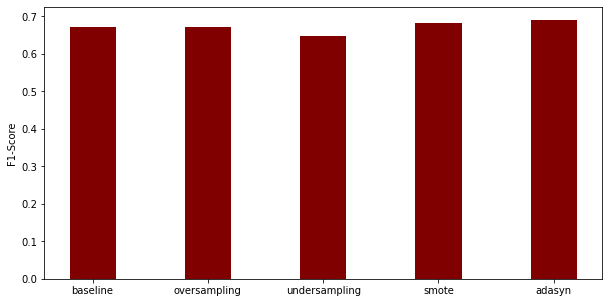

In [28]:
import matplotlib.pyplot as plt

scalers = list(f1.keys())
f_scores = list(f1.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(scalers, f_scores, color ='maroon',
        width = 0.4)
 
plt.xlabel("")
plt.ylabel("F1-Score")
plt.show()

In [29]:
accuracy, precision, recall, f1

({'baseline': 0.776536312849162,
  'oversampling': 0.7597765363128491,
  'undersampling': 0.7318435754189944,
  'smote': 0.7597765363128491,
  'adasyn': 0.7597765363128491},
 {'baseline': 0.5942028985507246,
  'oversampling': 0.6376811594202898,
  'undersampling': 0.6376811594202898,
  'smote': 0.6666666666666666,
  'adasyn': 0.6956521739130435},
 {'baseline': 0.7735849056603774,
  'oversampling': 0.7096774193548387,
  'undersampling': 0.6567164179104478,
  'smote': 0.696969696969697,
  'adasyn': 0.6857142857142857},
 {'baseline': 0.6721311475409837,
  'oversampling': 0.6717557251908397,
  'undersampling': 0.6470588235294118,
  'smote': 0.6814814814814815,
  'adasyn': 0.6906474820143885})